# DeepDreaming with TensorFlow

Based on https://www.tensorflow.org/tutorials/generative/deepdream

In [1]:
!nvidia-smi

Thu Oct 27 18:43:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib as mpl

import IPython.display as display
import PIL.Image

import time


2.9.2


### Load and display image

In [3]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

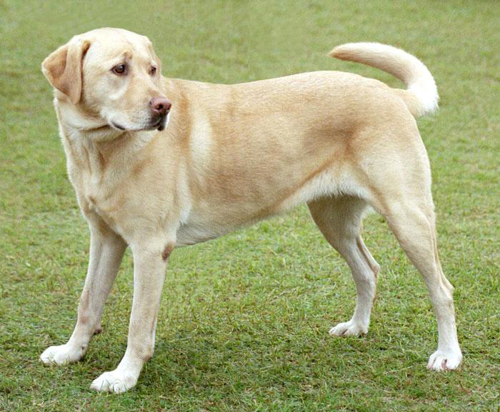

In [4]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image (from [-1,1] to [0,255])
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [5]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)


In [6]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    #print(loss)
    losses.append(loss)

  return  tf.reduce_sum(losses)

<a id='naive'></a>
## Simple Deep Dream

In [7]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model
    self.steps=10
    self.step_size=tf.convert_to_tensor(0.01)

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        )
  )
  def __call__(self, img):

      step_size = self.step_size
      steps = self.steps

      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1) # keep the image between -1,1

      return loss, img
      
deepdream = DeepDream(dream_model)

### Simple Deep Dream Demo

In [8]:
img = original_img # pixels between 0 and 255
print(np.min(img),np.max(img))

img = tf.keras.applications.inception_v3.preprocess_input(img)
img = tf.convert_to_tensor(img)

for iter in np.arange(5):
  loss, img = deepdream(img)

  #display.clear_output(wait=True)
  show(deprocess(img))
  print ("Iter {}, loss {}".format(iter, loss))

Output hidden; open in https://colab.research.google.com to view.

### Multiscale deep dream

In [9]:
start = time.time()

img = original_img # pixels between 0 and 255
print(np.min(img),np.max(img))

#img = tf.keras.applications.inception_v3.preprocess_input(img)
#img = tf.convert_to_tensor(img)

OCTAVE_SCALE = 1.30

#img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
#for n in np.arange(1,2):
  print(f'n: {n}')
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)

  for iter in np.arange(5):
    loss, img = deepdream(img)
  img = deprocess(img)
  show(img)
  #img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)
  
end = time.time()
end-start

Output hidden; open in https://colab.research.google.com to view.

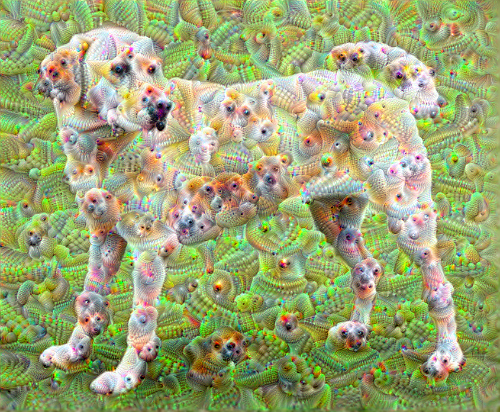

In [10]:
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)
